### Imports and Paths

In [1]:
# Widen Jupyter NB cell display
from IPython.core.display import display, HTML, Image
display(HTML("<style>.container { width:100% !important; }</style>"))
# Set-up python print formating
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [2]:
import numpy as np, os
import matplotlib.pyplot as plt
import pandas as pd, random
import seaborn as sn
import torch, torch.nn as nn

from PIL import Image
from tqdm import tqdm
from torch.optim import SGD, AdamW
from torch.utils import data
from torchvision import transforms, models
from pydicom import read_file
from pydicom.pixel_data_handlers.util import apply_voi_lut

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/root/venv/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# CHANGE TO YOUR LOCAL
path = "/media/bryan/3777c7d8-50a4-4e8a-9d41-1ac8670b3dd3/vindr/physionet.org/files/vindr-spinexr/1.0.0/"

train_path = path + "train_images/"
test_path  = path + "test_images/"
annot_path = path + "annotations/"

tiny_path = "/".join(path.split("/")[:-2]) + "/tiny_vindr/"
#os.makedirs(tiny_path, exist_ok=True)
#os.makedirs(tiny_path + "train_images/", exist_ok=True)
#os.makedirs(tiny_path + "test_images/", exist_ok=True)
#os.makedirs(tiny_path + "annotations/", exist_ok=True)

### Read DICOM files

In [10]:
def read_xray(path, voi_lut=True, fix_monochrome=True):
    
    dicom = read_file(path)
    # transform raw DICOM data to "human-friendly" view
    if voi_lut and len(dicom.get("VOILUTSequence", [])):
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array.astype("float")

    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    data -= np.min(data)
    data /= np.max(data)
    data *= 255
        
    return data.astype(np.uint8)

### Make Tiny Version

In [ ]:
annotations = pd.read_csv(annot_path + "train.csv")
annotations = annotations[["image_id", "lesion_type", "xmin", "ymin", "xmax", "ymax"]]
annotations.to_csv(tiny_path + "annotations/train.csv")

for dicom_file in tqdm(os.listdir(train_path)):

    name = dicom_file.split(".")[0]
    if not dicom_file.endswith("dicom"):
        continue
    a = read_xray(train_path + dicom_file)
    plt.imsave(tiny_path + f"train_images/{name}.jpg", a)

annotations = pd.read_csv(annot_path + "test.csv")
annotations = annotations[["image_id", "lesion_type", "xmin", "ymin", "xmax", "ymax"]]
annotations.to_csv(tiny_path + "annotations/test.csv")

for dicom_file in tqdm(os.listdir(test_path)):

    name = dicom_file.split(".")[0]
    if not dicom_file.endswith("dicom"):
        continue
    a = read_xray(test_path + dicom_file)
    plt.imsave(tiny_path + f"test_images/{name}.jpg", a)

### Load Training Splits

In [ ]:
def train_test_split(path):
    train_path = path + "train_images/"
    train_list = [os.path.join(train_path, img) for img in os.listdir(train_path)]

    random.shuffle(train_list)
    threshold = int(0.8 * len(train_list))
    valid_list = train_list[threshold:]
    train_list = train_list[:threshold]

    test_path = path + "test_images/"
    test_list = [os.path.join(test_path, img) for img in os.listdir(test_path)]

    return train_list, valid_list, test_list

path = "/media/bryan/3777c7d8-50a4-4e8a-9d41-1ac8670b3dd3/vindr/physionet.org/files/vindr-spinexr/tiny_vindr/"
train, valid, test = train_test_split(path)

In [ ]:
annotations = pd.read_csv(annot_path + "train.csv")
train_annot = [
    annotations.iloc[idx] for idx, row in enumerate(annotations.iterrows()) \
        if "{}train_images/{}.jpg".format(path, row[1]["image_id"]) in train
]
train_annot = pd.DataFrame(train_annot).drop_duplicates(subset=["image_id"]).sort_values(by=["image_id"])

valid_annot = [
    annotations.iloc[idx] for idx, row in enumerate(annotations.iterrows()) \
        if "{}train_images/{}.jpg".format(path, row[1]["image_id"]) in valid
]
valid_annot = pd.DataFrame(valid_annot).drop_duplicates(subset=["image_id"]).sort_values(by=["image_id"])

annotations = pd.read_csv(annot_path + "test.csv")
test_annot = [
    annotations.iloc[idx] for idx, row in enumerate(annotations.iterrows()) \
        if "{}test_images/{}.jpg".format(path, row[1]["image_id"]) in test
]
test_annot = pd.DataFrame(test_annot).drop_duplicates(subset=["image_id"]).sort_values(by=["image_id"])

In [ ]:
class VinDrSpineXR(data.Dataset):
    def __init__(self, root_dir, annot_df, transform=None):
        self.img_paths = root_dir
        self.img_paths.sort()
        self.transform = transform
        self.labels = annot_df[["image_id", "lesion_type"]]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = Image.open(self.img_paths[idx])
        #  0: Abnormal  |  1: Normal
        label = self.labels.iloc[idx, 1] == "No finding"
        image = self.transform(image)
        return image, label*1

train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = VinDrSpineXR(train, train_annot, train_transform)
valid_dataset = VinDrSpineXR(valid, valid_annot, train_transform)
test_dataset  = VinDrSpineXR(test , test_annot , test_transform )

train_loader = data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = data.DataLoader(valid_dataset, batch_size=32, shuffle=True)
test_loader  = data.DataLoader(test_dataset , batch_size=32, shuffle=True)

### Build and Train Network Model

In [ ]:
class XRModel(nn.Module):
    def __init__(self, n_classes, use_pretrained=True, freeze=True):
        super(XRModel, self).__init__()

        self.base_net = models.densenet169(pretrained=use_pretrained)
        if freeze:
            for child in self.base_net.children():
                for param in child.parameters():
                    param.requires_grad = False

        n_feats = self.base_net.classifier.in_features
        self.base_net.classifier = nn.Linear(n_feats, 256)
        self.cls = nn.Sequential(nn.LeakyReLU(), nn.Linear(256, n_classes))

    def forward(self, input):
        return (self.cls(self.base_net(input))).to(device)

model = XRModel(n_classes=2, freeze=False)
optim = AdamW(model.parameters(), lr=1e-3)
lossf = nn.CrossEntropyLoss()

In [ ]:
model = model.to(device)
n_epochs = 30
batch_size=32
best_val_loss = 999999999
acc_list = []
val_acc_list = []
loss_list = []
val_loss_list = []

for i in range(1, n_epochs+1):

    print(f"\nEpoch {i}:")
    print("-"*10)

    running_loss, running_hits = 0.0, 0.0
    for batch, label in tqdm(train_loader):
        images = batch.to(device)
        labels = label.to(device)

        optim.zero_grad()
        with torch.set_grad_enabled(True):

            out = model(images)
            loss = lossf(out, labels)
            _, pred = torch.max(out, 1)
            loss.backward()
            optim.step()
    
        running_loss += loss.item()
        running_hits += (torch.sum(pred == labels)).item() / batch_size

    epoch_loss = running_loss / len(train_loader)
    epoch_acc  = running_hits / len(train_loader)
    acc_list.append(epoch_acc)
    loss_list.append(epoch_loss)
    print("Train Loss: {:.3f}\t Acc: {:.3f}".format(epoch_loss, epoch_acc))

    running_loss, running_hits = 0.0, 0.0
    for batch, label in tqdm(valid_loader):
        images = batch.to(device)
        labels = label.to(device)

        optim.zero_grad()
        with torch.set_grad_enabled(False):

            out = model(images)
            loss = lossf(out, labels)
            _, pred = torch.max(out, 1)
    
        running_loss += loss.item()
        running_hits += (torch.sum(pred == labels)).item() / batch_size

    epoch_loss = running_loss / len(valid_loader)
    epoch_acc  = running_hits / len(valid_loader)
    val_acc_list.append(epoch_acc)
    val_loss_list.append(epoch_loss)
    if epoch_loss < best_val_loss:            
        torch.save(model.state_dict(), 'vindr_densenet169.h5')
        best_val_loss = epoch_loss
    print("Valid Loss: {:.3f}\t Acc: {:.3f}".format(epoch_loss, epoch_acc))
np.save('acc_list.npy',np.asarray(acc_list))
np.save('val_acc_list.npy',np.asarray(val_acc_list))
np.save('loss_list.npy',np.asarray(loss_list))
np.save('val_loss_list.npy',np.asarray(val_loss_list))

In [ ]:
from sklearn import metrics
import seaborn as sn
from sklearn.metrics import ConfusionMatrixDisplay

def model_pred_on_test(model,model_h5_file,batch_size):
    test_loader  = data.DataLoader(test_dataset , batch_size=batch_size, shuffle=False)
    model = model.to(device)
    model.load_state_dict(torch.load(model_h5_file))
    model.eval()
    meta_preds = torch.zeros(1,1).to(device).float()
    meta_labels = torch.zeros(1,1).to(device).float()
    running_hits = 0
    
    for batch, label in tqdm(test_loader):
        images = batch.to(device)
        labels = label.to(device)

        out = model(images)
        _, pred = torch.max(out, 1)
        pred = pred.view(1,pred.shape[0])
        meta_preds = torch.cat((meta_preds,pred.float()),1)
        meta_labels = torch.cat((meta_labels,torch.unsqueeze(labels.float(),1)),0)
        running_hits += (torch.sum(pred == labels)).item()
    
    meta_preds = meta_preds.view(len(test)+1)
    meta_preds = meta_preds[1:].cpu().numpy()
    meta_labels = meta_labels.view(len(test)+1)
    meta_labels = meta_labels[1:].cpu().numpy()
    test_acc  = running_hits / len(test)
    fpr, tpr, thresholds = metrics.roc_curve(meta_labels, meta_preds, pos_label=1)
    auroc = metrics.auc(fpr, tpr)
    tn, fp, fn, tp = metrics.confusion_matrix(meta_labels, meta_preds).ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    F1 = (2*recall*precision)/(recall+precision)
    specificity = tn/(tn+fp)
    
    print("AUROC = ",np.round(auroc,4))
    print("F1 score = ",np.round(F1,4))
    print("Sensitivity = ",np.round(recall,4))
    print("Specificity = ",np.round(specificity,4))
    print("Accuracy on test set = ",np.round(test_acc,4))
    
    conf_matrix = metrics.confusion_matrix(y_true=meta_labels, y_pred=meta_preds)
    ls = [0, 1]
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=ls)
    disp.plot(cmap=plt.cm.Blues)
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('True', fontsize=18)
    plt.title('Confusion Matrix, Test Set', fontsize=18)
    plt.savefig('cm.png', dpi=1200)
    plt.show()

    return(meta_preds,meta_labels)

meta_preds,meta_labels = model_pred_on_test(model,'vindr_densenet169.h5',32)

In [3]:
acc_list = np.load('acc_list.npy')
val_acc_list = np.load('val_acc_list.npy')
loss_list = np.load('loss_list.npy')
val_loss_list = np.load('val_loss_list.npy')

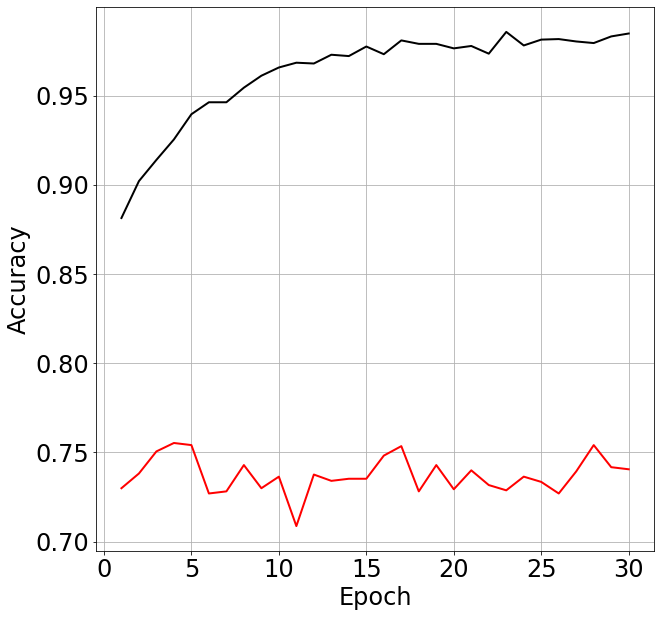

In [5]:
epochs = range(1,31)
plt.plot(epochs, acc_list, 'k', label='Training',linewidth=2)
plt.plot(epochs, val_acc_list, 'r', label='Validation',linewidth=2)
#plt.title('Training and Validation Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.rcParams['figure.figsize'] = [10,10]
plt.rcParams['font.size']= 24
#plt.legend()
plt.grid(b=True)
plt.savefig('acc.png', dpi=1200)
plt.show()

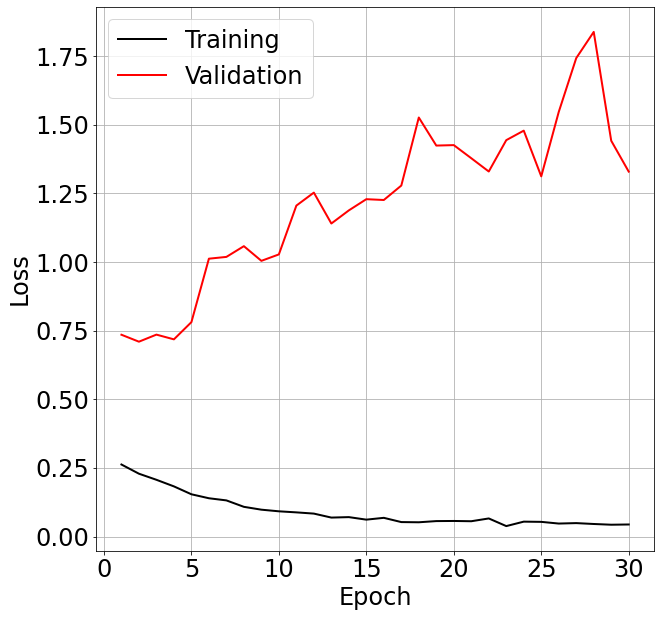

In [6]:
epochs = range(1,31)
plt.plot(epochs, loss_list, 'k', label='Training',linewidth=2)
plt.plot(epochs, val_loss_list, 'r', label='Validation',linewidth=2)
#plt.title('Training and Validation Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.rcParams['figure.figsize'] = [10,10]
plt.rcParams['font.size']= 24
plt.legend()
plt.grid(b=True)
plt.savefig('loss.png', dpi=1200)
plt.show()